In [23]:

using Plots
using PlutoUI; pyplot()
using LaTeXStrings

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


In [5]:
function randDisturbance(distMax)
    return (rand() - 0.5) * 2 * distMax
end
function calculateAmplitute(results)
    turning_points = []

    for t in 2:size(results)[1]

        #if the product of velocities is less than 0, this means we have a sign change.
        if(results[t-1, 2] * results[t, 2] < 0)
            append!(turning_points, 0.5 * (results[t-1, 1] + results[t, 1]))
        end

    end

    sum = 0
    for t in turning_points
        sum += abs(t)
    end
    sum /= size(turning_points)[1]
    return sum
end
mutable struct DataStore
    results;
    minX; maxX; avgAmp;
    function DataStore(results)
        minX = min(results...)
        maxX = max(results...)
        avgAmp = calculateAmplitute(results)
        return new(results, minX, maxX, avgAmp)
    end
end
function runSHO(k, m, x0, tSteps, dt, measureFreq=-1, measureMax=0)

    results = zeros(tSteps,2 )
    if(measureFreq == -1)
        measureFreq = tSteps
    end
    v = 0
    x = x0
    for t in 1:tSteps
        acc = (- k * x) / m # ma = -kx
        v += acc * dt


        if(t % measureFreq  == 0)
            v += randDisturbance(measureMax)
        end

        x += v * dt

        results[t,1] = x
        results[t,2] = v
    end
    return DataStore(results)
end

runSHO (generic function with 3 methods)

┌ Info: Saved animation to 
│   fn = /home/nikita/Zeno_QM/Classical/Pendulum/sho.gif
└ @ Plots /home/nikita/.julia/packages/Plots/oZheM/src/animation.jl:104


Plots.AnimatedGif("/home/nikita/Zeno_QM/Classical/Pendulum/sho.gif")
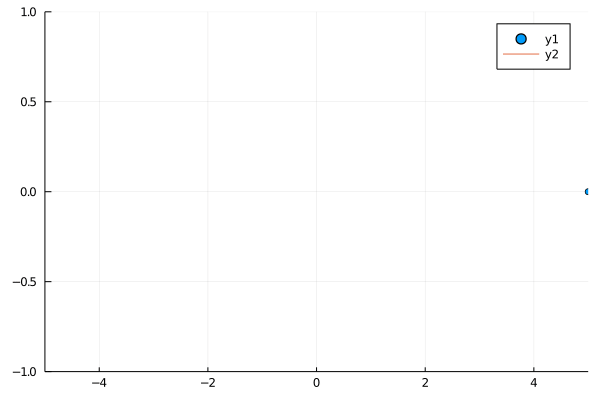

In [6]:


resExp1 = runSHO(1, 1, 5, 10000, 0.001)


animExp1 = Animation()
plot(title="test")
plot!(xlim = (resExp1.minX,resExp1.maxX), ylim=(-1,1))
let
    t_jump = 100
    for t in 1:t_jump:size(resExp1.results)[1]
        plot((resExp1.results[t], 0), seriestype = :scatter)
        plot!(xlim = (resExp1.minX,resExp1.maxX), ylim=(-1,1))

        trail = t>t_jump ? resExp1.results[t-t_jump:t, 1] : resExp1.results[1:t, 1]
        trail_y = zeros(size(trail)[1])
        plot!(trail, trail_y)

        frame(animExp1)
    end
end
gif(animExp1, "sho.gif", fps=200)


┌ Info: Saved animation to 
│   fn = /home/nikita/Zeno_QM/Classical/Pendulum/sho_measure_test.gif
└ @ Plots /home/nikita/.julia/packages/Plots/oZheM/src/animation.jl:104


Plots.AnimatedGif("/home/nikita/Zeno_QM/Classical/Pendulum/sho_measure_test.gif")
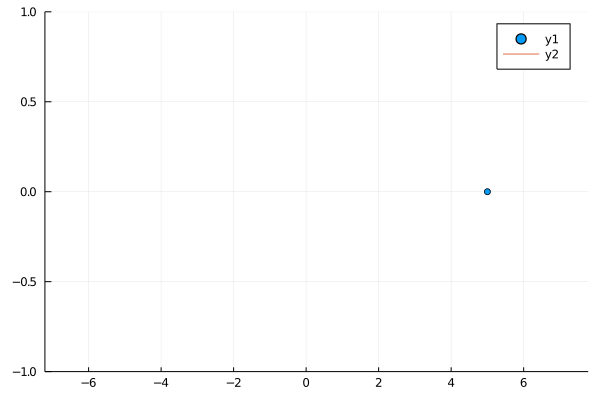

In [7]:


resExp2 = runSHO(1, 1, 5, 100000, 0.001, 1000, 2)


animExp2 = Animation()
plot(title="test")
plot!(xlim = (resExp2.minX,resExp2.maxX), ylim=(-1,1))

t_jump = 100
for t in 1:t_jump:size(resExp2.results)[1]
    plot((resExp2.results[t], 0), seriestype = :scatter)
    plot!(xlim = (resExp2.minX,resExp2.maxX), ylim=(-1,1))

    trail = t>t_jump ? resExp2.results[t-t_jump:t, 1] : resExp2.results[1:t, 1]
    trail_y = zeros(size(trail)[1])
    plot!(trail, trail_y)

    frame(animExp2)
end
gif(animExp2, "sho_measure_test.gif", fps=200)


In [28]:

total_steps = 640000 #640 thousand steps each
measure_freq = [-1,6400,3200,1600,800,400, 200, 100]
distMax = 0.5

iterations = 50

averageAmps = zeros(size(measure_freq)[1])
#we iterate all our measurement frequecies
Threads.@threads for it in 1:iterations

    for (i, mFreq) in enumerate(measure_freq)
        resExp_constDistMax = runSHO(1,1, 5, total_steps, 0.001, mFreq, distMax)
        averageAmps[i] += resExp_constDistMax.avgAmp
    end
end

averageAmps ./=iterations


8-element Array{Float64,1}:
  4.999999196136743
  5.421911975824704
  5.529654462775328
  5.8887812808589635
  6.677642278944887
  8.334119401075267
 10.800617390738596
 13.808607275568669

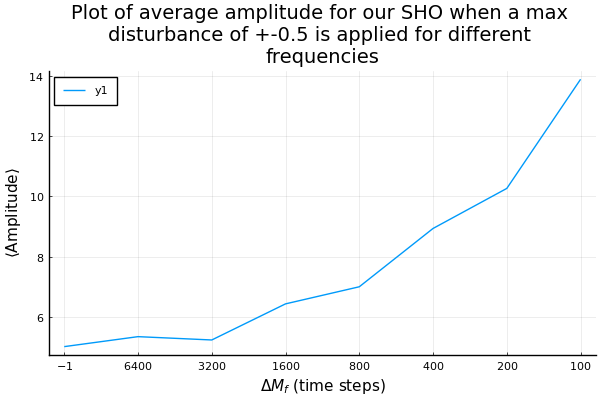

In [27]:


x = Array(1:size(measure_freq)[1])
p = plot(x, averageAmps)
plot!(xticks = (x, measure_freq))
plot!(title="Plot of average amplitude for our SHO when a max \ndisturbance of +-0.5 is applied for different \nfrequencies")
plot!(xlabel=L"$\Delta M_f$ (time steps)", ylabel=L"$\langle$Amplitude$\rangle$")
p
